### Tarea 1: 

Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [216]:
#Librerías necesarias

import cv2  
import numpy as np
import matplotlib.pyplot as plt

#### Desglose:

1º: Visualizar la imagen e identificar una moneda de la imagen. \
2º: Mostrar por pantalla el número de monedas y cantidad de dinero presente en la imagen.

##### Alternativa 1: findContours()
Búsqueda de contornos general para cualquier figura geométrica (mejor para la tarea 2)

(938, 473, 3)


Text(0.5, 1.0, 'findContours')

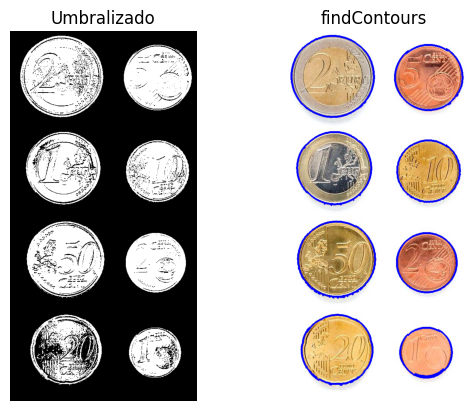

In [217]:
#Carga de la imagen de ejemplo con monedas
img = cv2.imread('Material_P3/Monedas.jpg') 
output = img.copy()
print(img.shape)

#Conversión a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#Conversión de la imagen a tonos de gris
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Umbralizado binario invertido
th,img_th = cv2.threshold(img_gris,200,255,cv2.THRESH_BINARY_INV)

#Muestra de la imagen
plt.subplot(121)
plt.axis("off")
plt.imshow(img_th, cmap='grey') 
plt.title('Umbralizado')

#Obtención de los contornos externos
contornos, hierarchy = cv2.findContours(
	img_th, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada los contornos en azul (se ve mejor)
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,0,255), 3)

plt.subplot(122)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('findContours')



(938, 473)


Text(0.5, 1.0, 'Suavizado')

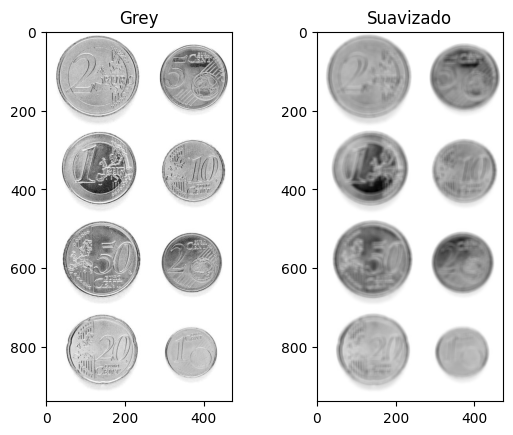

In [218]:
#-------------------------- Alternativa por Transformada de Hough -----------------------


#Reescalado si fuera necesario
height, width = img.shape[:2]

if(height < 800):
      scale = 800/height
      n_height = int(height*scale)
      n_width = int(width*scale)

      output = cv2.resize(img, (n_width, n_height), interpolation=cv2.INTER_CUBIC)
elif (height > 1500):
      scale = 1000/height
      n_height = int(height*scale)
      n_width = int(width*scale)

      output = cv2.resize(img, (n_width, n_height), interpolation=cv2.INTER_CUBIC)
#Conversión a escala de gris
gris = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
print(gris.shape)

plt.subplot(121)
plt.imshow(gris, cmap='grey') 
plt.title('Grey')

#Suavizado (Gaussiano da mejores resultados)
pimg = cv2.GaussianBlur(gris, (9,9), 11)

plt.subplot(122)
plt.imshow(pimg, cmap='grey') 
plt.title('Suavizado')

Text(0.5, 1.0, 'Hough')

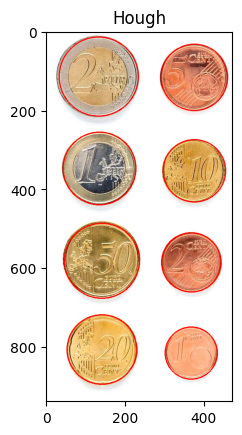

In [219]:
#Hallar círculos mediante el método alternativo de gradiente de Hough (más preciso, más estricto en la selección de parámetros)
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT_ALT,  # tipo de detección
        1.5,
        50,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=0.9, # umbral acumulador
    )


#Filtro para eliminar duplicados concéntricos
filt_circ = []

# Parámetro de distancia mínima para filtrar centros muy cercanos
dist_umbral = 30

# Filtrar círculos basados en la distancia entre sus centros
for i in range(len(circ[0, :])):
    actual = circ[0, i]
    centro_actual = (actual[0], actual[1])  
    radio_actual = actual[2]
    # Variable para verificar si el círculo es duplicado
    duplicado = False
    # Comparar con los círculos ya filtrados
    for circle in filt_circ:
        centro_filtrado = (circle[0], circle[1])
        # Calcular la distancia entre los centros de los círculos
        distancia = np.linalg.norm(np.array(centro_actual) - np.array(centro_filtrado))
        # Si la distancia es menor que el umbral, consideramos que es un duplicado
        if distancia < dist_umbral:
            duplicado = True
            break
    
    # Si no es un duplicado, agregar el círculo a la lista de filtrados
    if not duplicado:
        filt_circ.append(actual)

for det in filt_circ:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 0, 255), 2)
        cv2.circle(output,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 0, 255), 2)
#Dibujo sobre entrada e imagen vacía
img_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)



#Muestra resultado
plt.plot()
plt.imshow(img_rgb) 
plt.title('Hough')

### Clasificación de monedas
Se procede a clasificar las monedas por diametro y ratio entre las detectadas a partir de los datos obtenidos por transformación de Hough.

Clasificación de monedas

In [220]:
#Ordenar lista por radio de las circunferencias detectadas
s_circ = sorted(filt_circ, key = lambda circle: circle[2], reverse=True)

# Posible alternativa automática (cálculo a partir del mayor radio sin necesidad de hacer click en una moneda de referencia)
#Obtener proporcion
#max_r = s_circ[0][2];
#rat = [(x,y,r, r/max_r) for x,y,r in s_circ]

#Método para comprobar si un valor está cerca de otro dada una tolerancia
def close_val(val, opt1, opt2):
    diff1 = abs(val-opt1)
    diff2 = abs(val-opt2)
    return (diff1 < diff2)

monedas = [
    ("two_euro", 25.75),
    ("one_euro", 23.25), 
    ("fifty_cts", 24.25), 
    ("twenty_cts", 22.25), 
    ("ten_cts", 19.75), 
    ("five_cts", 21.25), 
    ("two_cts", 18.75), 
    ("one_cts", 16.25)
]

base_prop = [(k, r/23.25) for k, r in monedas]

#Método para mostrar información de elementos detectados
def show_data(arr):
    print("Circunferencias ordenadas y proporciones de radio:")
    for circle in arr:
        print(f"Círculo (x: {circle[0]}, y: {circle[1]}, radio: {circle[2]: .2f}) - Proporción: {circle[3]:.3f}")




ref = None
def callback_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Si se hace clic con el botón izquierdo
        
        for circle in s_circ:
            if (x - circle[0])**2 + (y - circle[1])**2 <= circle[2]**2:
                ref = circle
                break;

        classify(ref)


def classify(ref):
    coins = [(x, y, r, r/ref[2]) for x,y,r in s_circ]

    for coin in coins:
        rel_prop = ("None", 2)
        for prop in base_prop:
            if (close_val(coin[3], prop[1], rel_prop[1])):
                rel_prop = prop
            
        cv2.putText(output, f"{rel_prop[0]}", (int(coin[0]-50), int(coin[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        print(f"Lab: {rel_prop[0]}; (x: {coin[0]}, y: {coin[1]}, radio: {coin[2]: .2f}) - Proporción: {coin[3]:.3f}")
                
            



In [221]:

for prop in base_prop:
    print(f"Label: {prop[0]}, Proportion: {prop[1]: .3f}")

print(f"Se han detectado {len(circ[0])} circunferencias")


cv2.namedWindow('Imagen')

while(True):      
    cv2.imshow('Imagen', output)
    cv2.setMouseCallback('Imagen', callback_mouse)
    
    # Detención pulsando ESC
    if cv2.waitKey(20) == 27:
        break

cv2.destroyAllWindows()

Label: two_euro, Proportion:  1.108
Label: one_euro, Proportion:  1.000
Label: fifty_cts, Proportion:  1.043
Label: twenty_cts, Proportion:  0.957
Label: ten_cts, Proportion:  0.849
Label: five_cts, Proportion:  0.914
Label: two_cts, Proportion:  0.806
Label: one_cts, Proportion:  0.699
Se han detectado 11 circunferencias
Lab: two_euro; (x: 133.5, y: 115.5, radio:  100.89) - Proporción: 1.088
Lab: fifty_cts; (x: 141.0, y: 582.0, radio:  95.80) - Proporción: 1.034
Lab: one_euro; (x: 135.0, y: 348.0, radio:  92.69) - Proporción: 1.000
Lab: twenty_cts; (x: 141.0, y: 807.0, radio:  88.43) - Proporción: 0.954
Lab: five_cts; (x: 375.0, y: 117.0, radio:  84.16) - Proporción: 0.908
Lab: ten_cts; (x: 375.0, y: 354.0, radio:  79.74) - Proporción: 0.860
Lab: two_cts; (x: 367.5, y: 586.5, radio:  75.94) - Proporción: 0.819
Lab: one_cts; (x: 367.5, y: 816.0, radio:  66.51) - Proporción: 0.718
